<a href="https://colab.research.google.com/github/Aaron-k12/NLP_1/blob/master/Hot_dog_vs_not_hot_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

In [3]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

In [4]:
train_ds, valid_ds = ds["train"], ds["validation"]

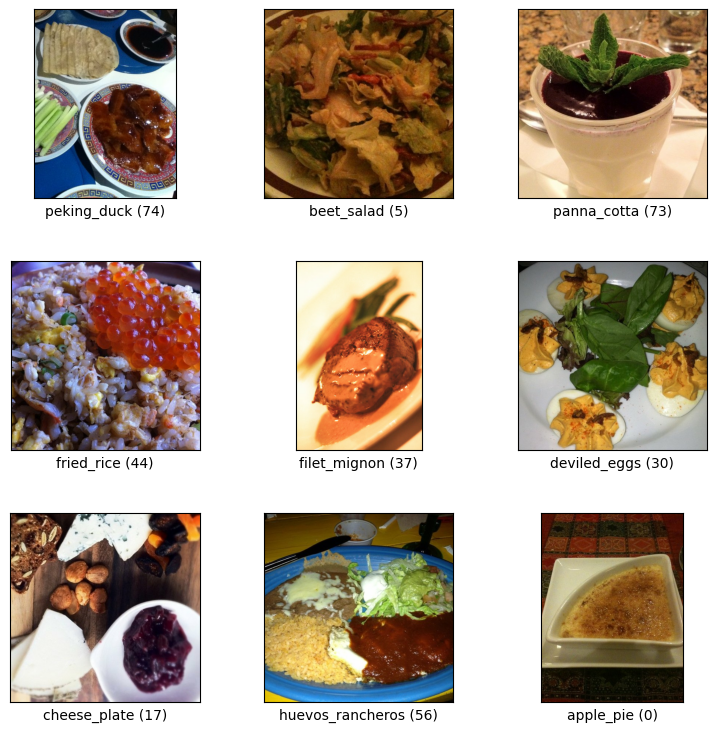

In [5]:
fig = tfds.show_examples(train_ds, ds_info)

In [6]:
#resizing image
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, tf.int32))
    )
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, tf.int32))
    )

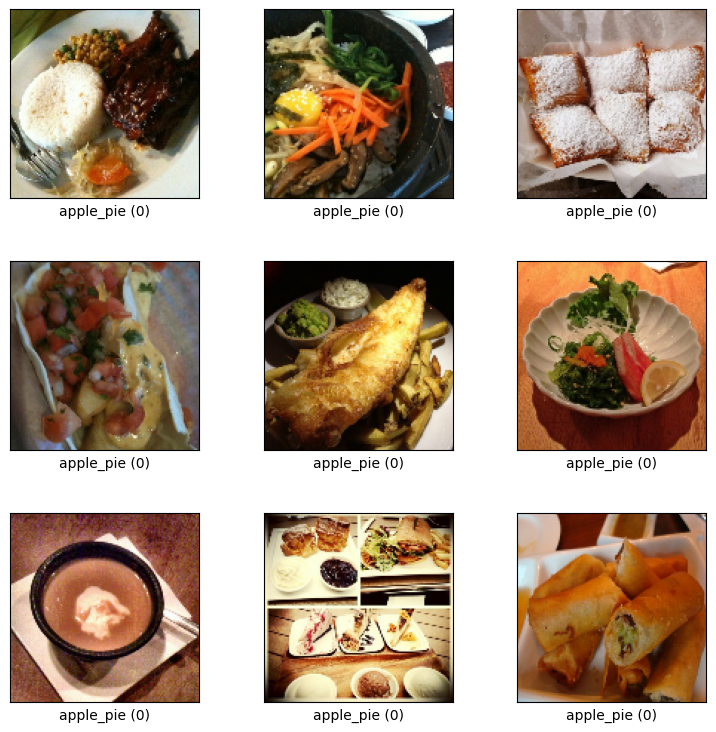

In [7]:
fig = tfds.show_examples(train_ds, ds_info)

In [8]:
train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda image, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda image, label: label == 0)

In [9]:
valid_hotdogs = valid_ds.filter(lambda image, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda image, label: label == 0)

In [10]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [11]:
for image_batch, label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[ 21  25  30]
   [ 23  25  30]
   [ 23  24  28]
   ...
   [ 37  35  48]
   [ 45  40  53]
   [ 56  41  53]]

  [[ 26  27  31]
   [ 23  23  28]
   [ 26  25  31]
   ...
   [ 37  36  47]
   [ 42  40  50]
   [ 52  43  51]]

  [[ 37  30  29]
   [ 34  27  27]
   [ 35  29  32]
   ...
   [ 42  39  50]
   [ 40  36  45]
   [ 48  43  49]]

  ...

  [[145  93  90]
   [144  89  88]
   [146  87  86]
   ...
   [ 33  25  36]
   [ 44  41  49]
   [ 42  39  43]]

  [[150  97  95]
   [143  88  86]
   [147  88  88]
   ...
   [ 45  34  43]
   [ 49  42  51]
   [ 61  55  61]]

  [[152  99  97]
   [148  93  92]
   [152  93  93]
   ...
   [ 50  34  44]
   [ 43  31  41]
   [ 51  39  47]]]


 [[[253 255 254]
   [253 254 253]
   [254 254 252]
   ...
   [254 254 254]
   [255 255 255]
   [255 255 255]]

  [[253 254 253]
   [253 255 254]
   [253 255 254]
   ...
   [252 252 252]
   [253 253 253]
   [255 255 255]]

  [[255 255 253]
   [253 255 254]
   [236 240 241]
   ...
   [ 30  30  30]
   [254 254 254]


Neural Net Implementation

In [24]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [28]:
for i,_ in ds["train"].take(1):
  image = i

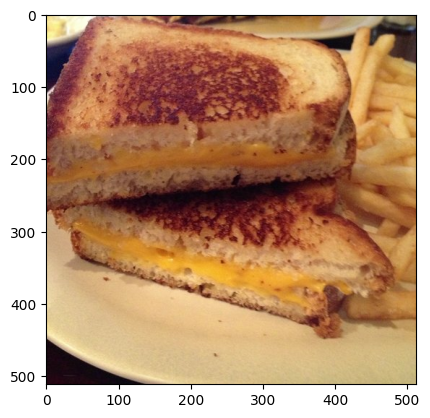

In [29]:
plt.imshow(image)

In [30]:
image = tf.cast(tf.expand_dims(image, 0), tf.float32)
image /= 255.0

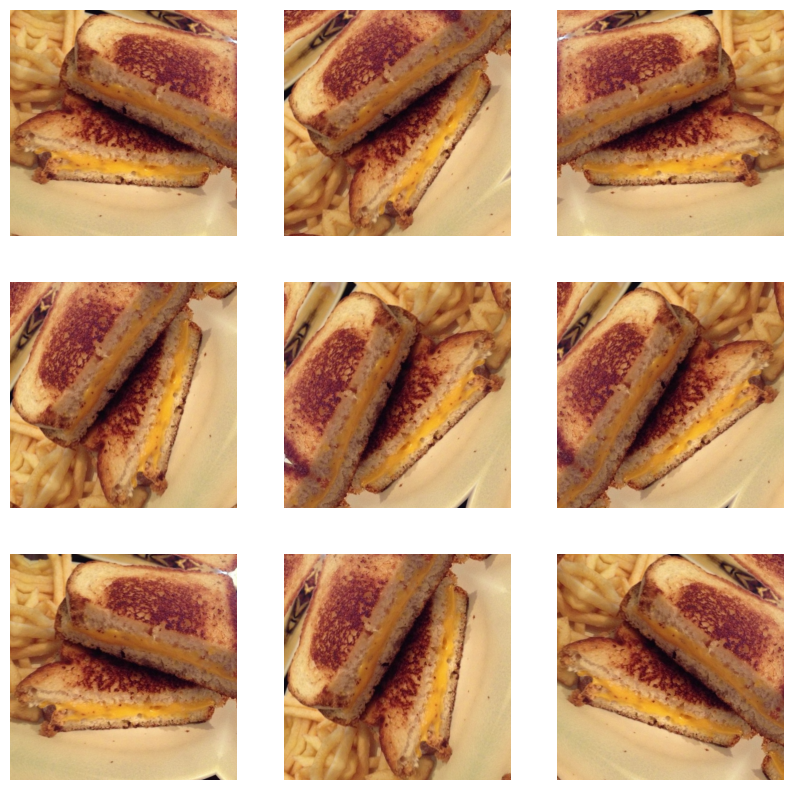

In [31]:
plt.figure(figsize =(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(augmented_image[0])
  plt.axis("off")


In [34]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(data_augmentation)
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=[MAX_SIDE_LEN, MAX_SIDE_LEN, 3]))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01) ))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [35]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/50
277/277 [==============================] - 462s 2s/step - loss: 1.4350 - accuracy: 0.4925 - val_loss: 1.1838 - val_accuracy: 0.4835
Epoch 2/50
277/277 [==============================] - 6s 21ms/step - loss: 1.0363 - accuracy: 0.5172 - val_loss: 0.9317 - val_accuracy: 0.4848
Epoch 3/50
277/277 [==============================] - 6s 22ms/step - loss: 0.8670 - accuracy: 0.5394 - val_loss: 0.8240 - val_accuracy: 0.4890
Epoch 4/50
277/277 [==============================] - 6s 22ms/step - loss: 0.7918 - accuracy: 0.5534 - val_loss: 0.7694 - val_accuracy: 0.4979
Epoch 5/50
277/277 [==============================] - 6s 22ms/step - loss: 0.7494 - accuracy: 0.5593 - val_loss: 0.7332 - val_accuracy: 0.5055
Epoch 6/50
277/277 [==============================] - 6s 22ms/step - loss: 0.7225 - accuracy: 0.5774 - val_loss: 0.7104 - val_accuracy: 0.5165
Epoch 7/50
277/277 [==============================] - 6s 22ms/step - loss: 0.7040 - accuracy: 0.5885 - val_loss: 0.6813 - val_accuracy: 0.5523

In [37]:
plt.figure(figsize =(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

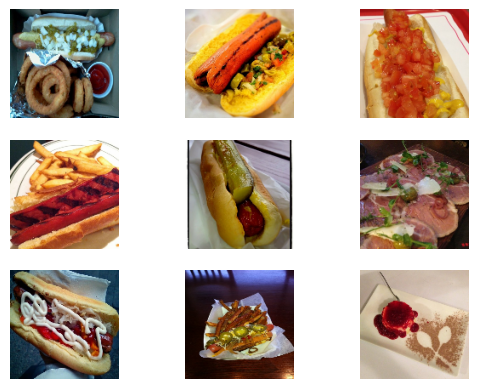

In [38]:

for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [39]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 1, 1, 1, 1, 0, 1, 1, 0], dtype=int32)>